In [1]:
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import datetime as dt
import glob
import zipfile
import tqdm
import xarray as xr
import os

def reconstruct_grid(f, group_id):
        
        #From h5 grid objects (f), reconstruct the radar grid
        
        bbox = f[group_id].attrs["bbox"]
        x = f["lon/lon"][:]
        y = f["lat/lat"][:]
        recon = np.zeros(x.shape)
        recon[bbox[0]:bbox[2],bbox[1]:bbox[3]] = f[group_id+"/cell_mask"][:]
        
        return recon, x, y

def unpack_level1b(rid, times):
        #Unzip level1b data between times[0] and times[1], and save to scratch
        assert times[0].year == times[1].year, "Times range must be within calendar year"
        files = np.array(glob.glob("/g/data/rq0/level_1b/"+rid+"/grid/"+str(times[0].year)+"/*.zip"))
        if len(files) == 0:
                print("NO FILES FOUND FOR RID: ")#+rid+" AND TIMES "+times[0]+" "+times[-1])
        file_dates = np.array([dt.datetime.strptime(f.split("/")[8].split("_")[1], "%Y%m%d") for f in files])
        target_files = files[(file_dates >= times[0].replace(hour=0, minute=0, second=0)) & (file_dates <= times[1].replace(hour=0, minute=0,second=0))]
        extract_to = "/scratch/w40/ab4502/tint/"
        for f in target_files:
                with zipfile.ZipFile(f, "r") as zip_ref:
                        zip_ref.extractall(extract_to)    
    
def load_radar(rid, time, radar_t_delta=0):

    #time: Time of interest (in this context, the time of maximum BARPAC gust). datetime object
    #rid: Radar ID (https://www.openradar.io/operational-network). two-digit string
    #radar_t_delta: Add some interval (in minutes) to look at a time relative to the time of maximum model gust. integer
    

    #Unpack gridded radar files. Create empty files based on missing files reported in Level 2
    times = [time+dt.timedelta(seconds=-60), time+dt.timedelta(seconds=60)]
    unpack_level1b(rid, times)
    grid_files = np.sort(glob.glob("/scratch/w40/ab4502/tint/"+rid+"*_grid.nc"))
    file_dates = np.array([dt.datetime.strptime(f.split("/")[5].split("_")[1] + f.split("/")[5].split("_")[2],\
                    "%Y%m%d%H%M%S") for f in grid_files])
    target_files = grid_files[(file_dates >= times[0]) & (file_dates <= times[1])]    
        
    #radar_file = pyart.io.read_grid(target_files[0])
    radar_file = xr.open_dataset(target_files[0])
    
    _ = [os.remove(f) for f in grid_files]
    
    return radar_file   

def plot_stns(state, stns=False):
    
    names = ["id", "stn_no", "district", "stn_name", "site_open", "site_close", "lat", "lon", "latlon_method", "state",\
                    "hgt_asl", "hgt_asl_baro", "wmo_idx", "y1", "y2", "comp%", "Y%", "N%", "W%", "S%", "I%", "#"]
    stn_df = pd.read_csv(glob.glob("/g/data/eg3/ab4502/ExtremeWind/obs/aws/"+state+"_one_min_gust/HD01D_StnDet_*.txt")[0],\
            names=names, header=0)    
    if stns:
        stn_df = stn_df[np.in1d(stn_df.stn_no, stns)]
        plt.plot(stn_df.lon, stn_df.lat, marker="*", color="tab:red", linestyle="none", ms=8)
    else:    
        plt.plot(stn_df.lon, stn_df.lat, marker="*", color="tab:red", linestyle="none", ms=8)        

100%|██████████| 4/4 [00:08<00:00,  2.17s/it]


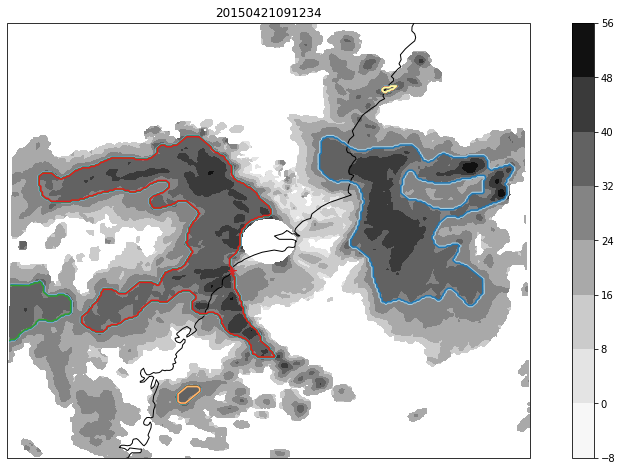

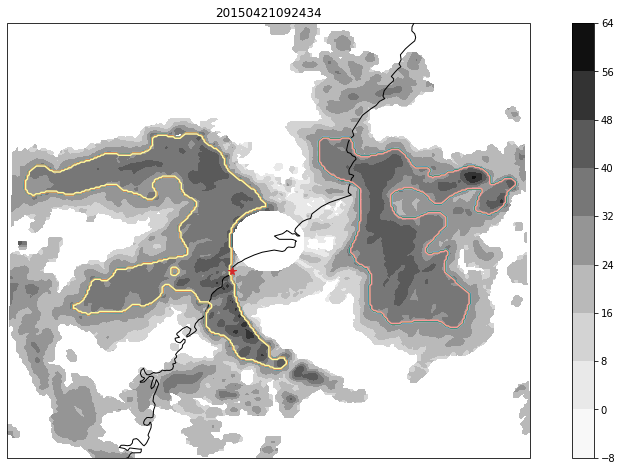

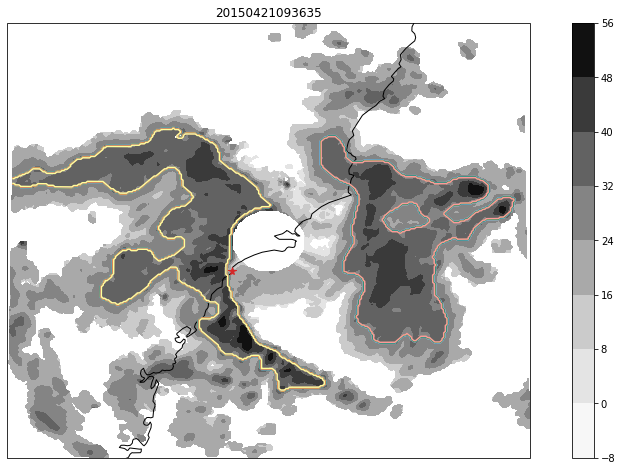

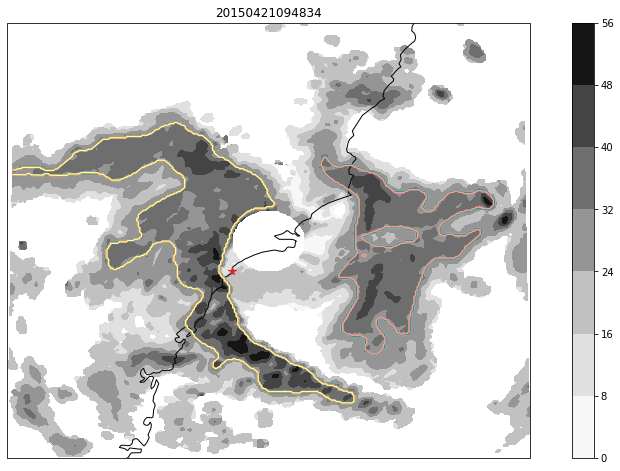

In [11]:
file_id = "4_20150401_20150430"
rid = h5py.File("/g/data/eg3/ab4502/TINTobjects/"+file_id+".h5", "r")
datetimes = np.array([dt.datetime.strptime(t,"%Y%m%d%H%M%S") for t in list(rid.keys())[0:-2]])
plot_times = [dt.datetime(2015,4,21,9,0), None]
delta = dt.timedelta(hours=1)
plot_times[1] = plot_times[0] + delta
state="nsw"
stns=[61055]

times = np.array(list(rid.keys()))[0:-2][(datetimes>=plot_times[0]) & (datetimes<=plot_times[1])]
for t in tqdm.tqdm(times):
    time = t
    out = np.zeros(rid["lat/lat"][:].shape)
    cnt=1
    for uid in list(rid[time].keys()):
        r, x, y = reconstruct_grid(rid,time+"/"+uid)
        out = np.where(r==1, cnt, out)
        cnt=cnt+1

    radar = load_radar(file_id.split("_")[0], dt.datetime.strptime(time, "%Y%m%d%H%M%S")).isel({"time":0,"nradar":0}).max("z")

    plt.figure(figsize=[15,8])
    ax=plt.axes(projection=ccrs.PlateCarree())
    c=ax.contour(x,y,out,cmap=plt.get_cmap("Paired"))
    ax.coastlines()
    c=ax.contourf(x,y,radar.corrected_reflectivity,cmap=plt.get_cmap("Greys"))#,levels=[0,30],extend="max")
    plt.colorbar(c)
    plt.title(time)
    plt.xlim([x.min(), x.max()])
    plt.ylim([y.min(), y.max()])            
    
    plot_stns(state, stns)
    
rid.close()